# Integration and reference mapping with multigrate

In this notebook we showcase Multigrate and integrate a CITE-seq dataset to obtain a joint gene expression and protein abundance representation in a latent space. Then we map the query onto the built reference. We use publically available dataset from NeurIPS 2021 workshop https://openproblems.bio/neurips_2021/.

For more examples, e.g. on how to use scArches with multigrate for trimodal integration of CITE-seq and multiome data, see multigrate's documentation https://multigrate.readthedocs.io/en/latest/index.html.

## Data loading

First, we download the dataset and split it into two AnnData objects, gene expression (RNA) and protein abundance (ADT).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import scarches as sca
import scanpy as sc
import anndata as ad
import muon

Global seed set to 0
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scarches/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scarches/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
!wget 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz'

--2022-11-08 16:56:23--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz
           => 'GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz'
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 165.112.9.230, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE194nnn/GSE194122/suppl ... done.
==> SIZE GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz ... 615842052
==> PASV ... done.    ==> RETR GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz ... done.
Length: 615842052 (587M) (unauthoritative)

100%[======================================>] 615,842,052 24.2MB/s   in 24s    

2022-11-08 16:56:49 (24.0 MB/s) - 'GSE194122_openproblems_neurips2021_cite_BMMC_processed.h

In [3]:
!gzip -d GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz

In [4]:
cite = sc.read('GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad')
cite

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
rna = cite[:, cite.var['feature_types'] == 'GEX'].copy()
adt = cite[:, cite.var['feature_types'] == 'ADT'].copy()
rna.shape, adt.shape

((90261, 13953), (90261, 134))

## RNA preprocessing

We normalize the counts and subset the genes to the batch-aware highly variable genes.

In [6]:
rna.X = rna.layers['counts'].copy()
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

In [7]:
sc.pp.highly_variable_genes(rna, n_top_genes=4000, batch_key='batch')
rna = rna[:, rna.var.highly_variable].copy()

## ADT preprocessing

We normalize the counts using the CLR transformation.

In [8]:
adt.X = adt.layers['counts'].copy()
muon.prot.pp.clr(adt)
adt.layers['clr'] = adt.X.copy()

## Subset into reference and query

We split the dataset into a reference (3 batches) and a query (2 batches).

In [9]:
reference_batches = ['s1d1', 's1d2', 's1d3']
query_batches = ['s2d1', 's2d4']

In [10]:
rna_query = rna[rna.obs['batch'].isin(query_batches)].copy()
adt_query = adt[adt.obs['batch'].isin(query_batches)].copy()
rna = rna[rna.obs['batch'].isin(reference_batches)].copy()
adt = adt[adt.obs['batch'].isin(reference_batches)].copy()

## Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. In this example we have 1 CITE-seq dataset, hence we input 2 anndata objects: 1 for RNA modality and 1 for ADT modality.

Notes:
- paired datasets have to have the same .obs_names, i.e. index
- each sublist in `adatas`, `layers` parameters corresponds to one modality. If you have multiple objects per modality, append them to the corresponding list;
- objects in each sublist *have* to have the same set of features: if you want to integrate multiple RNA objects, we recommend first concatenating full objects and then subsetting to 2000-4000 highly variable genes; for ADT modality, we take the intersection of available proteins (double check the naming conventions, as that can vary a lot from one dataset to another, so `.var_names` can have almost no intersection but if you align the protein names, then there is an overlap);
- `layers` parameter specifies which layer the model should take the counts from. If `None`, then defaults to `.X`. The distribution of the input data should be the same within a modality, e.g. here we use raw counts for RNA-seq modality.

In [11]:
adata = sca.models.organize_multiome_anndatas(
    adatas = [[rna], [adt]],            # a list of anndata objects per modality, RNA-seq always goes first
    layers = [['counts'], ['clr']],     # if need to use data from .layers, if None use .X
)
adata

AnnData object with n_obs × n_vars = 16311 × 4134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group'
    var: 'modality'
    uns: 'modality_lengths'
    layers: 'counts'

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size_factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified. Here we also want to correct for batch effects, so we specify  `batch` as a categorical covariate.

In [12]:
sca.models.MultiVAE.setup_anndata(
    adata, 
    categorical_covariate_keys=["batch"],
    rna_indices_end = 4000,
)

## Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. For ADT we use CLR-normalized counts and MSE loss. We need to specify `mmd='marginal'` and set the coeficient to the integration loss if we want to later map unimodal data onto this reference.

In [13]:
model = sca.models.MultiVAE(
    adata, 
    losses=['nb', 'mse'],
    loss_coefs={
               'integ': 5000,
    },
    mmd='marginal',
)

## Train the model

One can specify the number of epochs by setting `max_epochs` parameter, default is 256. The default batch size is set to `batch_size = 256`, adjust if needed.

In [14]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scarches/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [04:54<00:00,  1.39s/it, loss=1.44e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:54<00:00,  1.47s/it, loss=1.44e+03, v_num=1]


Let's plot losses.

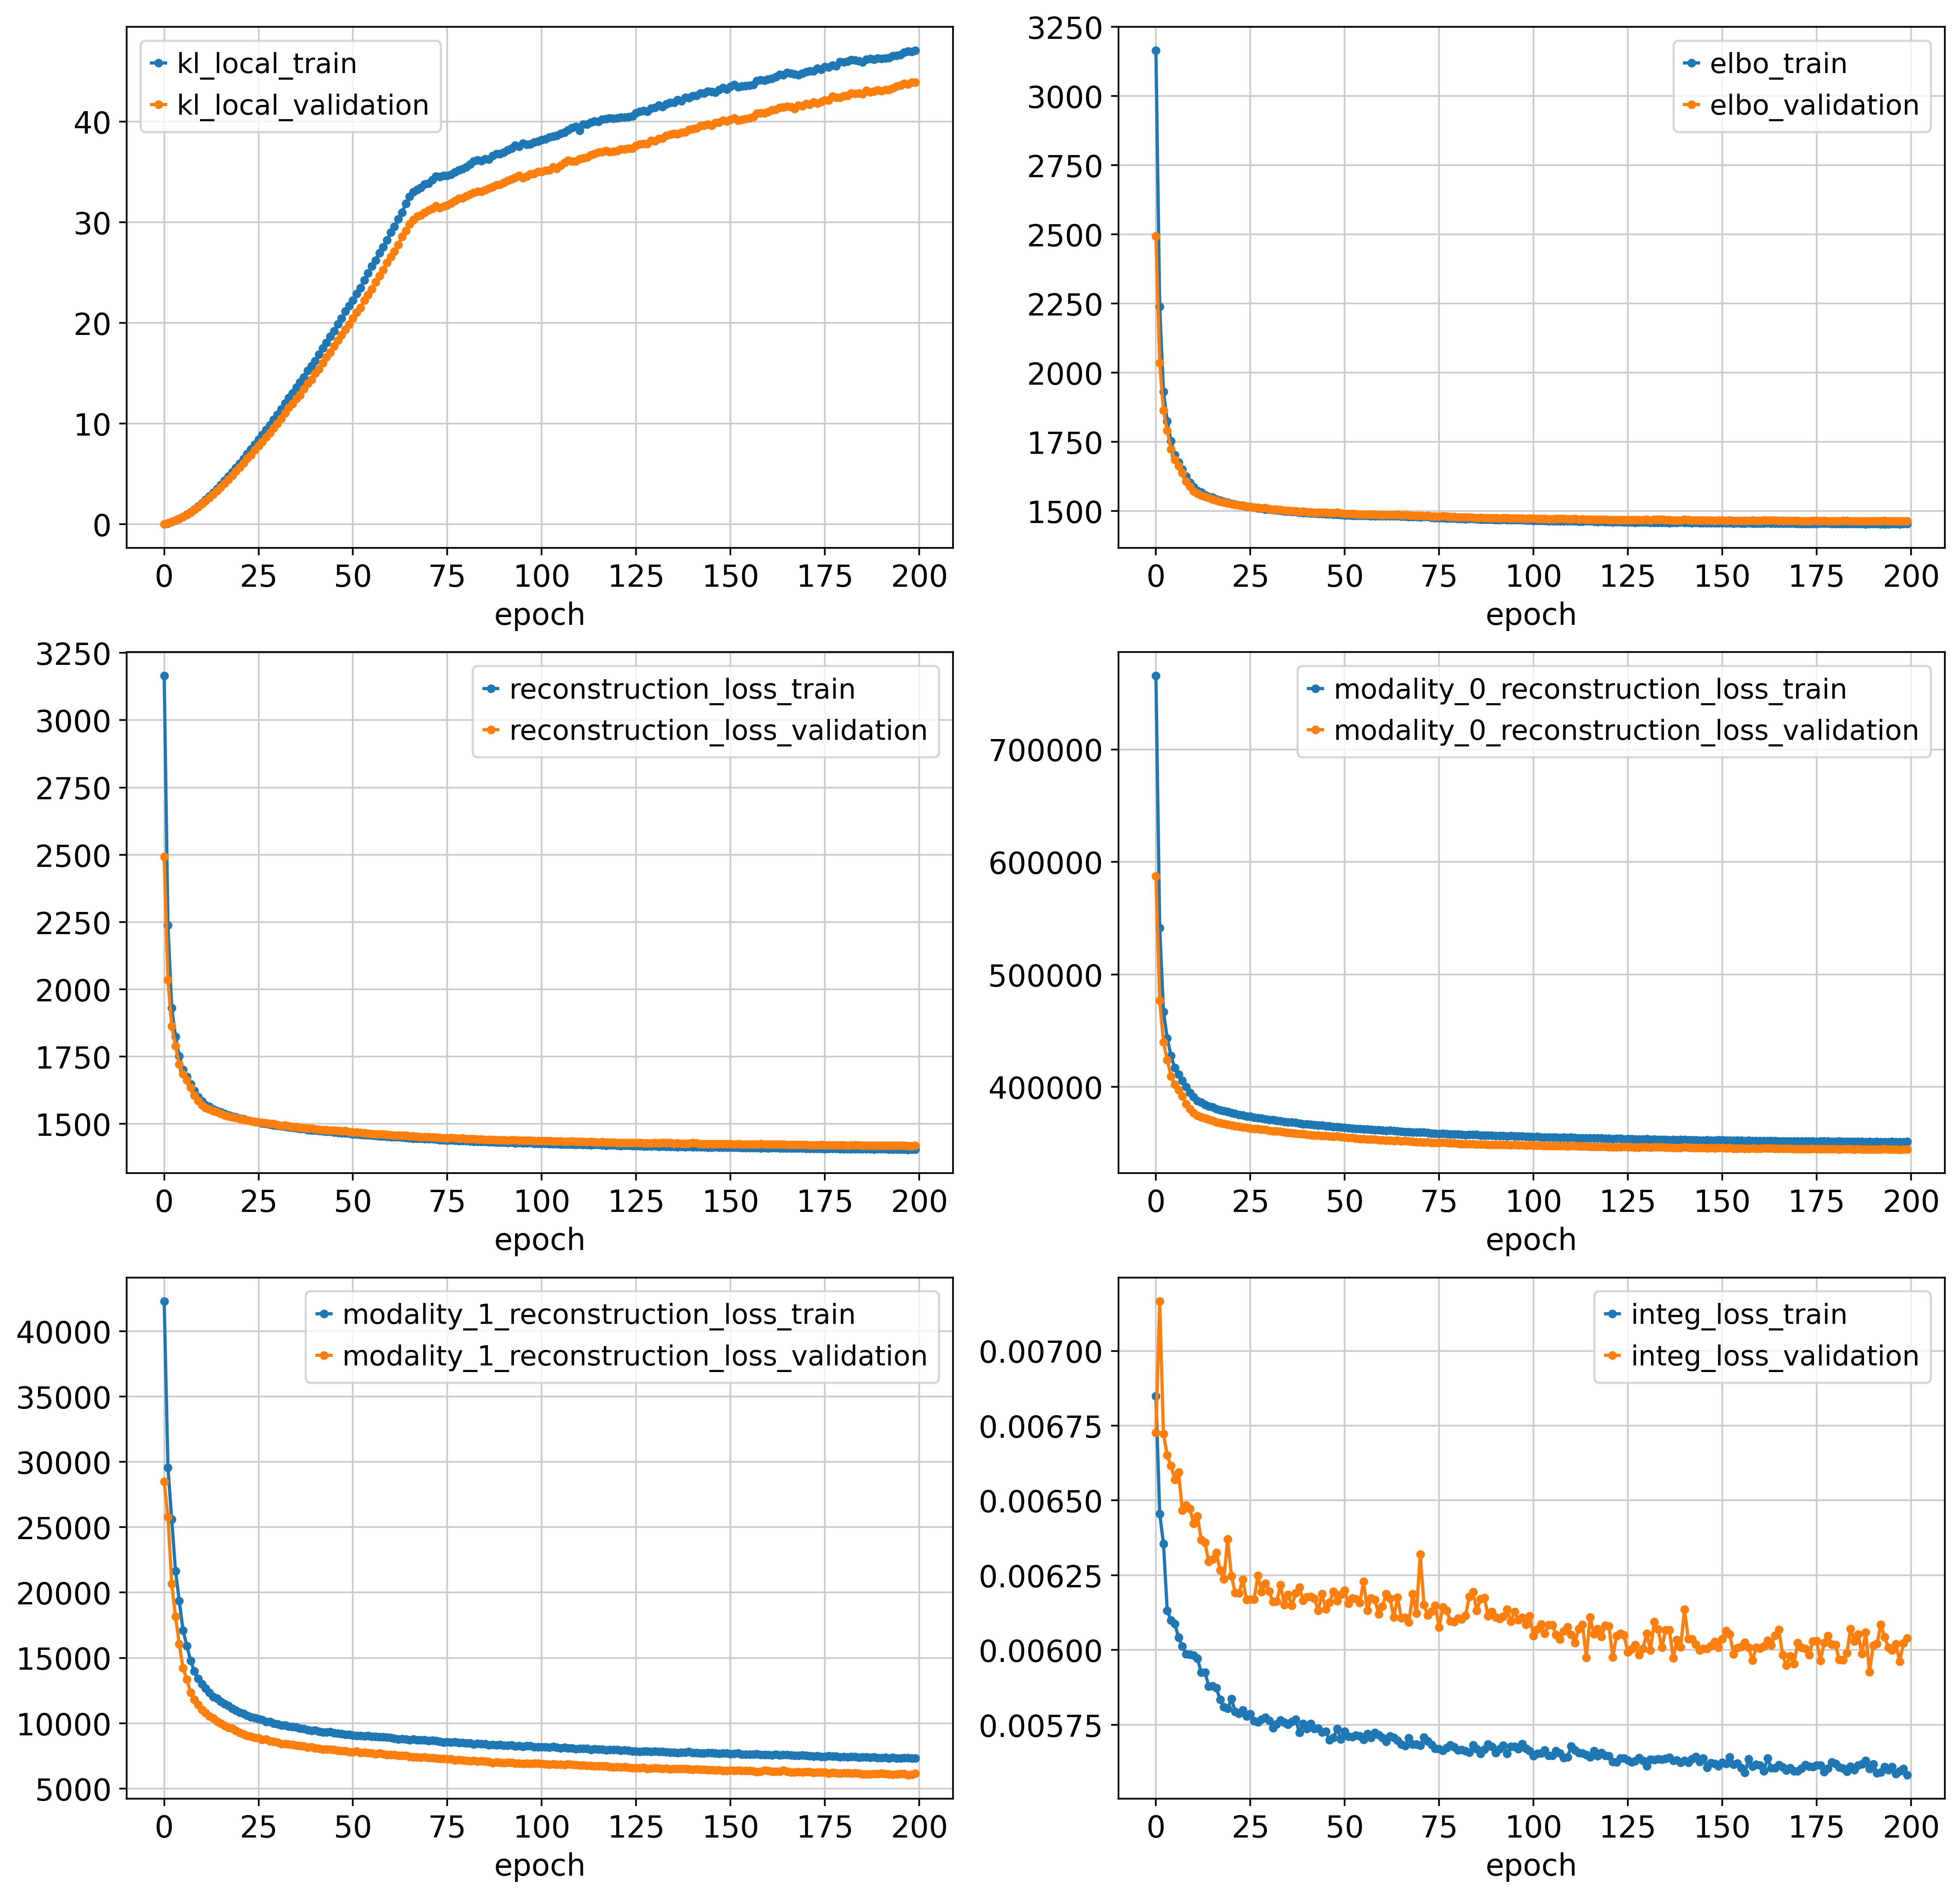

In [15]:
model.plot_losses()

## Inference

Get the latent representation.

In [16]:
model.get_latent_representation()
adata.obsm['latent_ref'] = adata.obsm['latent'].copy()
adata

AnnData object with n_obs × n_vars = 16311 × 4134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'latent', 'latent_ref'
    layers: 'counts'

Visualize the integrated latent embedding.

In [17]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

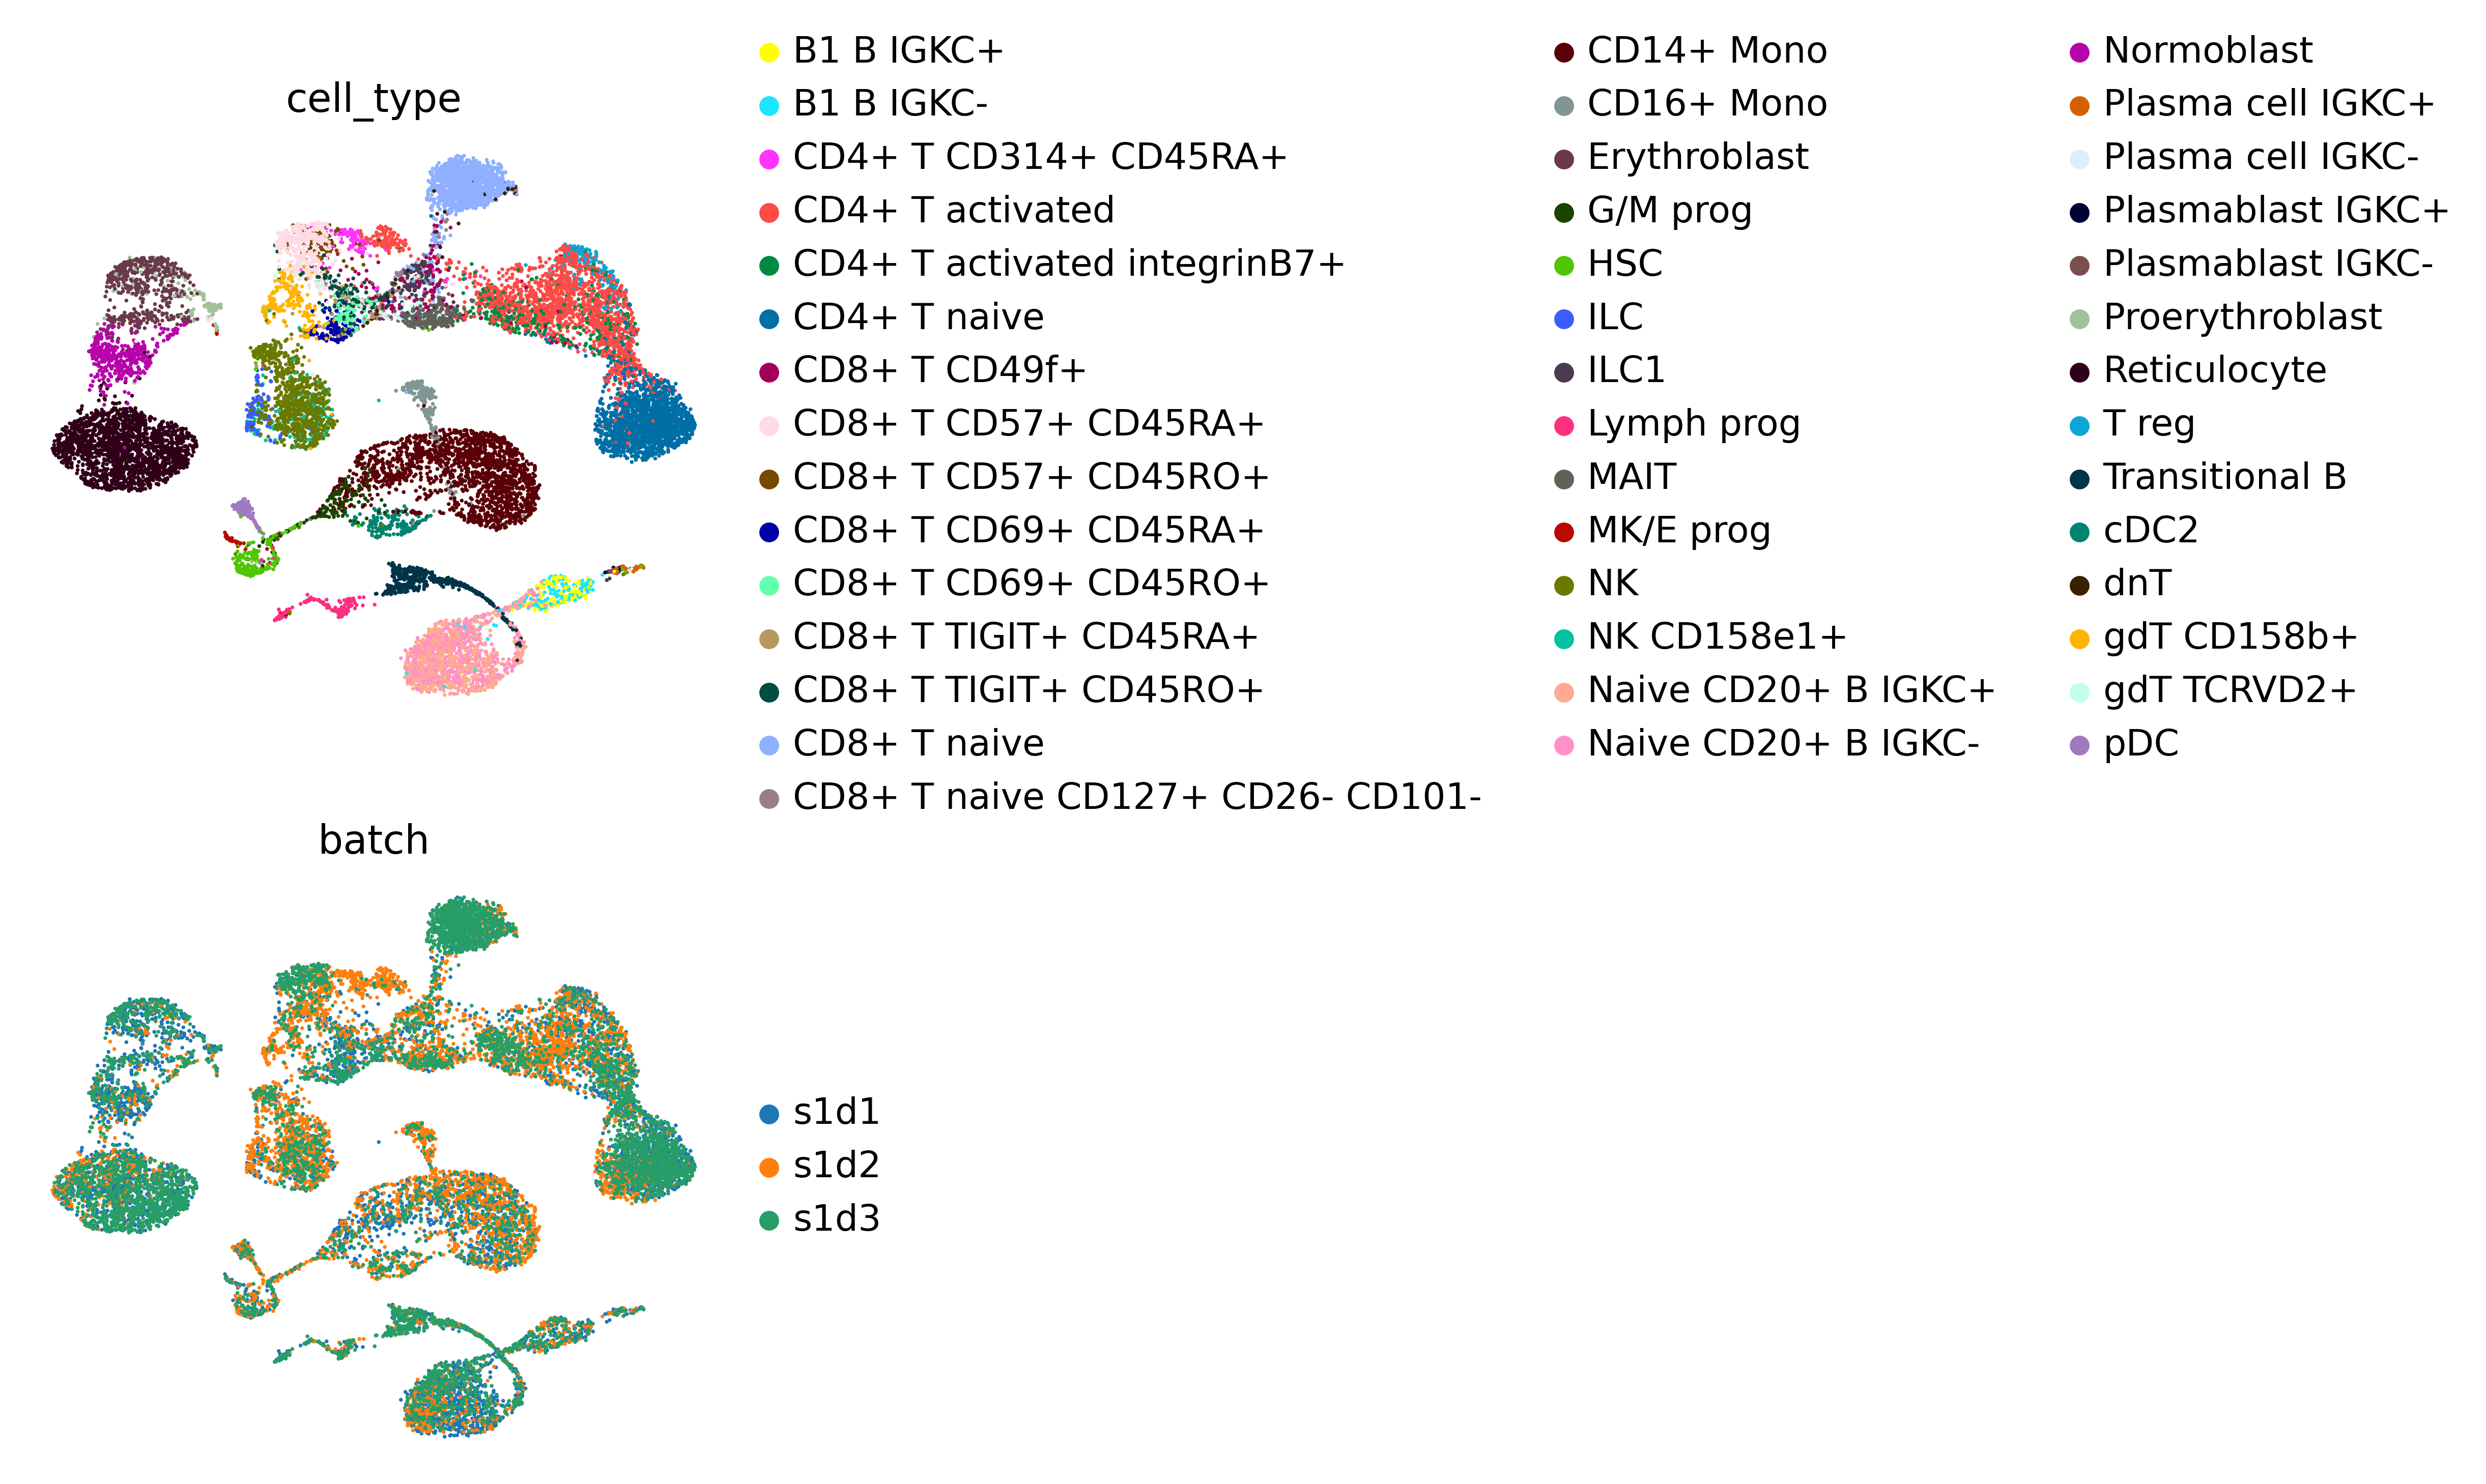

In [18]:
sc.pl.umap(adata, color=['cell_type', 'batch'], frameon=False, ncols=1)

## Query mapping

We repeat the same steps for the setting up the query as for the reference before.

In [19]:
query = sca.models.organize_multiome_anndatas(
    adatas = [[rna_query], [adt_query]],
    layers = [['counts'], ['clr']],
)

In [20]:
sca.models.MultiVAE.setup_anndata(
    query,
    categorical_covariate_keys=["batch"],
    rna_indices_end=4000,
)

We imitate a unimodal RNA-seq query by masking with zeros the ADT part of one batch.

In [21]:
idx_rna_query = query.obs['batch'] == 's2d1'
idx_cite_query = query.obs['batch'] == 's2d4'

In [22]:
query[idx_rna_query, 4000:].X = 0

In [23]:
q_model = sca.models.MultiVAE.load_query_data(query, model)

In [ ]:
q_model.train(weight_decay=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scarches/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 160/200:  80%|████████  | 160/200 [02:23<00:35,  1.12it/s, loss=1.22e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 1044.809. Signaling Trainer to stop.


In [ ]:
q_model.get_latent_representation(batch_size=256, adata=query)
q_model.get_latent_representation(batch_size=256, adata=adata)

In [ ]:
adata.obs['reference'] = 'reference'
query.obs['reference'] = 'query'

adata.obs['type_of_query'] = 'reference'
query.obs.loc[idx_rna_query, 'type_of_query'] = 'scRNA-seq query'
query.obs.loc[idx_cite_query, 'type_of_query'] = 'CITE-seq query'

In [ ]:
adata_both = ad.concat([adata, query])

In [ ]:
sc.pp.neighbors(adata_both, use_rep='latent')
sc.tl.umap(adata_both)

In [ ]:
sc.pl.umap(adata_both, color=['cell_type', 'type_of_query', 'batch'], ncols=1, frameon=False)